# Image pre-processing

In [1]:
from PIL import Image

In [19]:
# crop original image, only keep middle left area
def crop_img(img_path):
    im = Image.open(img_path)
    width, height = im.size
    
    left = 0
    top = height / 4
    right = width / 2
    bottom = 3 * height / 4
    
    result = im.crop((left, top, right, bottom))
    return result

In [16]:
import numpy as np
import os
from tqdm import tqdm

In [29]:
# transform all frames into cropped image focusing on drill
for dirname in tqdm(next(os.walk("data"))[1]):
    for filename in os.listdir("data/"+dirname):
        p = "data/"+dirname+"/"+filename
        result = crop_img(p)
        result.save(p, quality=95)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:33<00:00,  8.54s/it]


# Split train and test dataset
## train 80%, test 20%

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [53]:
data_dir = pathlib.Path("./data/img")
img_height = 480
img_width = 640
batch_size = 128

In [54]:
# get train dataset from image directory
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2157 files belonging to 9 classes.
Using 1726 files for training.


In [55]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2157 files belonging to 9 classes.
Using 431 files for validation.


In [56]:
class_names = train_ds.class_names
print(class_names)

['2.0 mm x 26 mm', '2.0 mm x 28 mm', '2.8 mm x 22 mm', '3.5 mm x 19 mm', '3.5 mm x 22 mm', '3.5 mm x 28 mm', '3.5 mm x 30 mm', '4.2 mm x 22 mm', '4.2 mm x 30 mm']


In [57]:
# normalize image dataset
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# First Model
## 30 min to train, test accuracy around 95%

In [58]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [59]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/10
14/14 [==============================] - 160s 11s/step - loss: 2.8755 - accuracy: 0.1535 - val_loss: 2.1400 - val_accuracy: 0.2436
Epoch 2/10
14/14 [==============================] - 231s 17s/step - loss: 1.9863 - accuracy: 0.3204 - val_loss: 1.7089 - val_accuracy: 0.4617
Epoch 3/10
14/14 [==============================] - 269s 19s/step - loss: 1.2706 - accuracy: 0.6338 - val_loss: 0.9164 - val_accuracy: 0.7193
Epoch 4/10
14/14 [==============================] - 146s 10s/step - loss: 0.4523 - accuracy: 0.8766 - val_loss: 0.4290 - val_accuracy: 0.8701
Epoch 5/10
14/14 [==============================] - 170s 12s/step - loss: 0.1395 - accuracy: 0.9768 - val_loss: 0.2702 - val_accuracy: 0.8956
Epoch 6/10
14/14 [==============================] - 188s 13s/step - loss: 0.0463 - accuracy: 0.9948 - val_loss: 0.1838 - val_accuracy: 0.9490
Epoch 7/10
14/14 [==============================] - 193s 14s/step - loss: 0.0215 - accuracy: 0.9988 - val_loss: 0.1799 - val_accuracy: 0.9513
Epoch 

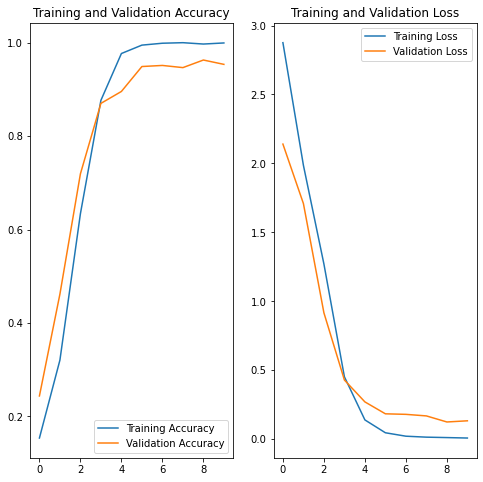

In [61]:
# plot training and testing performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [65]:
# try a test image
test_img = "origin_img/35x19dark_frames/frame0-00-20.00.png"
test_img = crop_img(test_img)

img_array = tf.keras.utils.img_to_array(test_img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
class_names[np.argmax(score)]

1/1 [==============================] - 0s 58ms/step


'3.5 mm x 19 mm'

# Second Model - add dropout
## 50 min to train, test accuracy around 96%

In [68]:
model2 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # add dropout to avoid overfitting
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [69]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [70]:
epochs = 15
history2 = model2.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/15
14/14 [==============================] - 143s 10s/step - loss: 4.6588 - accuracy: 0.1576 - val_loss: 2.1985 - val_accuracy: 0.1508
Epoch 2/15
14/14 [==============================] - 164s 12s/step - loss: 2.1194 - accuracy: 0.3210 - val_loss: 1.9749 - val_accuracy: 0.3550
Epoch 3/15
14/14 [==============================] - 203s 14s/step - loss: 1.6888 - accuracy: 0.5272 - val_loss: 1.7005 - val_accuracy: 0.4060
Epoch 4/15
14/14 [==============================] - 213s 15s/step - loss: 0.9327 - accuracy: 0.7630 - val_loss: 0.8650 - val_accuracy: 0.7448
Epoch 5/15
14/14 [==============================] - 203s 14s/step - loss: 0.3330 - accuracy: 0.9264 - val_loss: 0.4428 - val_accuracy: 0.8469
Epoch 6/15
14/14 [==============================] - 201s 14s/step - loss: 0.1000 - accuracy: 0.9815 - val_loss: 0.3237 - val_accuracy: 0.8840
Epoch 7/15
14/14 [==============================] - 187s 13s/step - loss: 0.0406 - accuracy: 0.9930 - val_loss: 0.1804 - val_accuracy: 0.9466
Epoch 

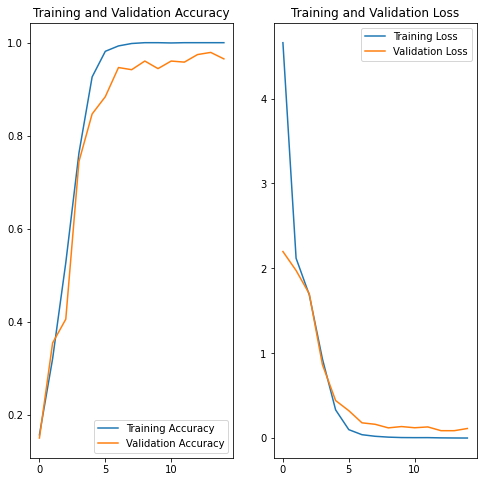

In [73]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Serialization

In [74]:
model2.save('my_model')

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets
